## Sentiment proportions over time (time buckets)

This notebook:
- loads nuclear-mention matches with `nuclear_sentiment`
- joins publication date from the full actor-statement dataset (via `id`)
- buckets time into `num_bins`
- plots **proportions** of sentiments (-1 / 0 / 1) per bucket


In [26]:
# Parameters
num_bins = 10  # <- change this to control the number of time buckets

# Paths (relative to repo root)
DATA_DIR = "../data"
MATCHES_CSV = f"{DATA_DIR}/nuclear_mentions_matches.csv"
FULL_DATASET_CSV = f"{DATA_DIR}/Actor statement corpus - dataset.csv"


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)


In [28]:
# Load data
matches = pd.read_csv(MATCHES_CSV)

# Ensure ids are comparable
matches["id"] = pd.to_numeric(matches["id"], errors="coerce")

# Parse sentiment as int (-1/0/1)
matches["nuclear_sentiment"] = pd.to_numeric(matches["nuclear_sentiment"], errors="coerce").astype("Int64")

# Prefer dates already present in matches (newer pipeline keeps original columns)
merged = matches.copy()

# If date/year are missing, fall back to joining from the full dataset
if ("Date of publication" not in merged.columns) or ("Year" not in merged.columns):
    full = pd.read_csv(FULL_DATASET_CSV)
    full["id"] = pd.to_numeric(full["id"], errors="coerce")
    merged = merged.merge(full[["id", "Date of publication", "Year"]], on="id", how="left")

# If merge created suffixes, pick the left-side date/year first
if "Date of publication" not in merged.columns:
    if "Date of publication_x" in merged.columns:
        merged["Date of publication"] = merged["Date of publication_x"]
    elif "Date of publication_y" in merged.columns:
        merged["Date of publication"] = merged["Date of publication_y"]

if "Year" not in merged.columns:
    if "Year_x" in merged.columns:
        merged["Year"] = merged["Year_x"]
    elif "Year_y" in merged.columns:
        merged["Year"] = merged["Year_y"]

# Parse date
a = merged["Date of publication"] if "Date of publication" in merged.columns else pd.Series(dtype="datetime64[ns]")
merged["Date of publication"] = pd.to_datetime(a, errors="coerce")

# Fallback: if Date is missing but Year exists, set date to Jan 1st of that year
if "Year" in merged.columns:
    merged["Year"] = pd.to_numeric(merged["Year"], errors="coerce")
    missing_date = merged["Date of publication"].isna() & merged["Year"].notna()
    merged.loc[missing_date, "Date of publication"] = pd.to_datetime(
        merged.loc[missing_date, "Year"].astype(int).astype(str) + "-01-01",
        errors="coerce",
    )

merged = merged.dropna(subset=["Date of publication", "nuclear_sentiment"]).copy()
merged[["id", "Date of publication", "Year", "nuclear_sentiment"]].head()

,id,Date of publication,Year,nuclear_sentiment
0,8,2024-06-13,2024,1
1,179,2024-12-06,2024,1
2,182,2024-12-06,2024,1
3,191,2024-12-07,2024,-1
4,193,2022-11-03,2022,1


In [29]:
# Create equal-width time buckets (fixed start date)
if num_bins < 1:
    raise ValueError("num_bins must be >= 1")

# Fixed start for comparability across runs
start = pd.Timestamp("2018-10-01")
end = merged["Date of publication"].max()

# pd.cut needs bin edges; convert to int64 nanoseconds for stable binning
x = merged["Date of publication"].view("int64")

start_ns = start.value
end_ns = end.value

# If end is earlier than the fixed start, fall back to min/max in data
if end_ns <= start_ns:
    start_ns = int(x.min())
    end_ns = int(x.max())

edges = np.linspace(start_ns, end_ns, num_bins + 1)
# Make sure edges are strictly increasing (rare corner case if all dates equal)
if np.all(edges == edges[0]):
    edges = np.array([edges[0] - 1, edges[0] + 1], dtype=np.int64)

labels = []
for i in range(len(edges) - 1):
    a = pd.to_datetime(int(edges[i]))
    b = pd.to_datetime(int(edges[i + 1]))
    labels.append(f"{a.date()} → {b.date()}")

merged["time_bucket"] = pd.cut(
    x,
    bins=edges,
    include_lowest=True,
    labels=labels,
)

merged[["Date of publication", "time_bucket", "nuclear_sentiment"]].head()

C:\Users\Elias\AppData\Local\Temp\ipykernel_6916\3874244603.py:10: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x = merged["Date of publication"].view("int64")


,Date of publication,time_bucket,nuclear_sentiment
0,2024-06-13,2024-05-07 → 2025-01-18,1
1,2024-12-06,2024-05-07 → 2025-01-18,1
2,2024-12-06,2024-05-07 → 2025-01-18,1
3,2024-12-07,2024-05-07 → 2025-01-18,-1
4,2022-11-03,2022-04-01 → 2022-12-13,1


In [30]:
# Proportions of sentiment per bucket
# Ensure consistent ordering of sentiment classes
sentiment_order = [-1, 0, 1]

counts = (
    merged.groupby(["time_bucket", "nuclear_sentiment"], dropna=False)
    .size()
    .unstack(fill_value=0)
)

for s in sentiment_order:
    if s not in counts.columns:
        counts[s] = 0
counts = counts[sentiment_order]

props = counts.div(counts.sum(axis=1), axis=0)

display(counts.head())
display(props.head())

C:\Users\Elias\AppData\Local\Temp\ipykernel_6916\343563540.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged.groupby(["time_bucket", "nuclear_sentiment"], dropna=False)


nuclear_sentiment,-1,0,1
time_bucket,,,
NaN,0,6,1
2018-10-01 → 2019-06-13,0,0,0
2019-06-13 → 2020-02-24,1,1,4
2020-02-24 → 2020-11-06,1,1,0
2020-11-06 → 2021-07-19,9,12,34


nuclear_sentiment,-1,0,1
time_bucket,,,
NaN,0.000000,0.857143,0.142857
2018-10-01 → 2019-06-13,NaN,NaN,NaN
2019-06-13 → 2020-02-24,0.166667,0.166667,0.666667
2020-02-24 → 2020-11-06,0.500000,0.500000,0.000000
2020-11-06 → 2021-07-19,0.163636,0.218182,0.618182


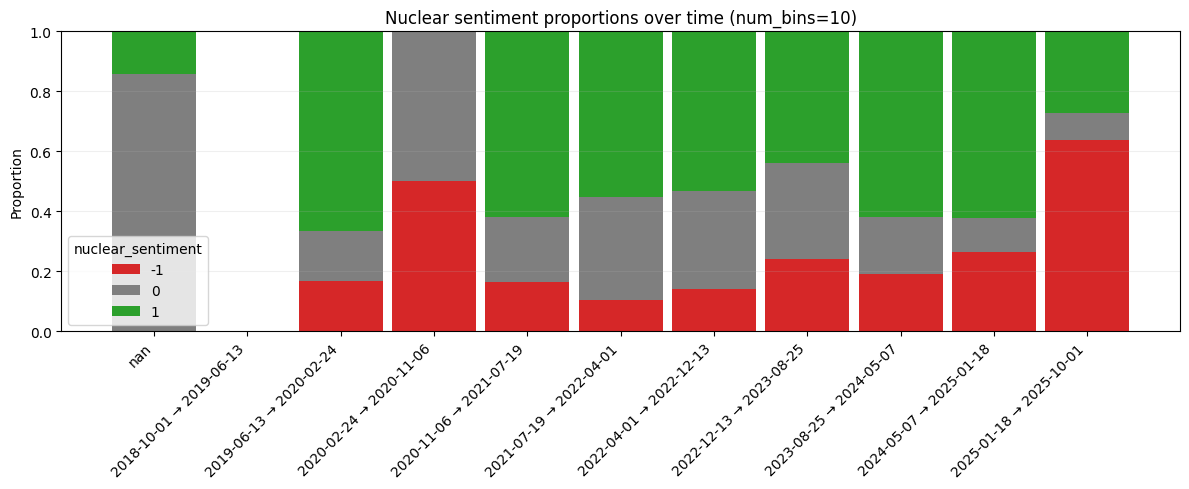

In [31]:
# Plot: stacked proportions per bucket
fig, ax = plt.subplots(figsize=(12, 5))

colors = {
    -1: "#d62728",  # red
    0: "#7f7f7f",   # gray
    1: "#2ca02c",   # green
}

bottom = np.zeros(len(props))
xpos = np.arange(len(props))

for s in sentiment_order:
    ax.bar(xpos, props[s].values, bottom=bottom, color=colors[s], label=str(s), width=0.9)
    bottom += props[s].values

ax.set_title(f"Nuclear sentiment proportions over time (num_bins={num_bins})")
ax.set_ylabel("Proportion")
ax.set_ylim(0, 1)
ax.set_xticks(xpos)
ax.set_xticklabels([str(x) for x in props.index], rotation=45, ha="right")
ax.legend(title="nuclear_sentiment")
ax.grid(axis="y", alpha=0.2)

plt.tight_layout()
plt.show()

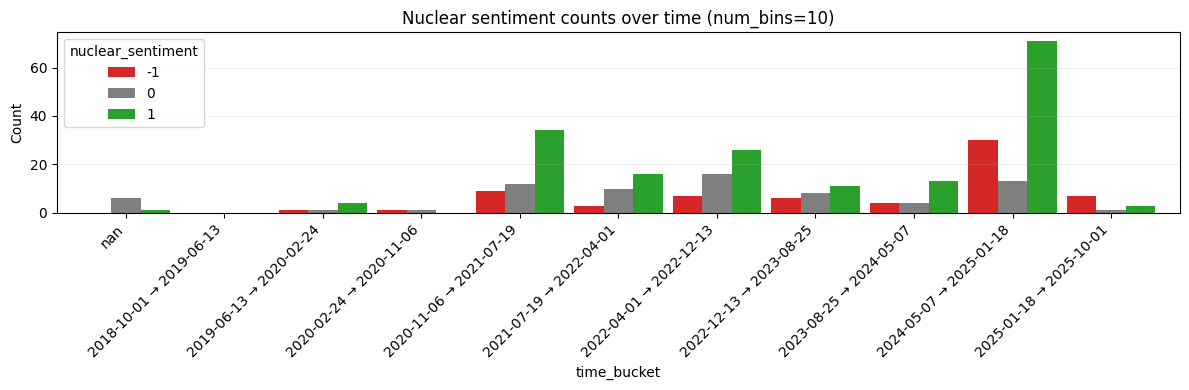

In [32]:
# (Optional) Also show raw counts
counts.plot(kind="bar", figsize=(12, 4), color=["#d62728", "#7f7f7f", "#2ca02c"], width=0.9)
plt.title(f"Nuclear sentiment counts over time (num_bins={num_bins})")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.2)
plt.tight_layout()
plt.show()